In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [38]:
mobile=keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [8]:
def prepare_image(file):
    img_path='D:\Coding\Learning\DL_Learning\Datasets\MobileNet-Samples/'
    img=image.load_img(img_path+file,target_size=(224,224))
    img_array=image.img_to_array(img)
    img_array_expanded_dims=np.expand_dims(img_array,axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

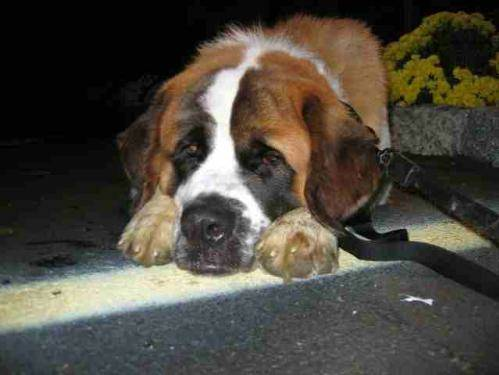

In [9]:
from IPython.display import Image
Image(filename='D:\Coding\Learning\DL_Learning\Datasets\MobileNet-Samples\dog.jpg', width=300, height=200)

In [5]:
preprocessed_image=prepare_image('dog.jpg')
predictions=mobile.predict(preprocessed_image)
results=keras.applications.mobilenet.decode_predictions(predictions)
results

1/1 [==============================] - 3s 3s/step


[[('n02109525', 'Saint_Bernard', 0.99899715),
  ('n02108089', 'boxer', 0.0005582319),
  ('n02101388', 'Brittany_spaniel', 0.00010196589),
  ('n02089973', 'English_foxhound', 6.097639e-05),
  ('n02107574', 'Greater_Swiss_Mountain_dog', 5.3673146e-05)]]

In [12]:
# Organize data into train, valid, test dirs
os.chdir('/Coding/Learning/DL_Learning/Datasets/Sign-Language-Digits-Dataset-master')
if os.path.isdir('train/0')==False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0,10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples=random.sample(glob.glob(f'train/{i}/*'), 30)
        for j in valid_samples:
            shutil.move(j, f'valid/{i}')
            
        test_samples=random.sample(glob.glob(f'train/{i}/*'), 10)
        for k in test_samples:
            shutil.move( k, f'test/{i}')

os.chdir('/Coding/Learning/DL_Learning/Keras_Learning')

In [13]:
train_path='/Coding/Learning/DL_Learning/Datasets/Sign-Language-Digits-Dataset-master/train/'
valid_path='/Coding/Learning/DL_Learning/Datasets/Sign-Language-Digits-Dataset-master/valid/'
test_path='/Coding/Learning/DL_Learning/Datasets/Sign-Language-Digits-Dataset-master/test/'

In [14]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,target_size=(224,224),classes=['0','1','2','3','4','5','6','7','8','9'],batch_size=10)

valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224,224),classes=['0','1','2','3','4','5','6','7','8','9'],batch_size=10)

test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),classes=['0','1','2','3','4','5','6','7','8','9'],batch_size=10,shuffle=False)

Found 1662 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


## Modify the MobileNet model

In [31]:
mobile=keras.applications.mobilenet.MobileNet()

In [52]:
# Create a sequential Model using all the layers except the last 5 layers
model=Sequential()
for layer in mobile.layers[:-5]:
    model.add(layer)

# Add GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# Add Dense layer with 10 neurons
model.add(Dense(units=10,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)     

In [53]:
# We will freeze all the layers expect the last 23 layers of the model
for layer in model.layers[:-23]:
    layer.trainable=False

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)     

## Train the model

In [55]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=30,
    verbose=2
)

Epoch 1/30
167/167 - 153s - loss: 0.6681 - accuracy: 0.8032 - val_loss: 0.6867 - val_accuracy: 0.7900 - 153s/epoch - 913ms/step
Epoch 2/30
167/167 - 112s - loss: 0.1212 - accuracy: 0.9813 - val_loss: 0.1344 - val_accuracy: 0.9633 - 112s/epoch - 668ms/step
Epoch 3/30
167/167 - 168s - loss: 0.0630 - accuracy: 0.9928 - val_loss: 0.0779 - val_accuracy: 0.9800 - 168s/epoch - 1s/step
Epoch 4/30
167/167 - 160s - loss: 0.0379 - accuracy: 0.9976 - val_loss: 0.0587 - val_accuracy: 0.9867 - 160s/epoch - 959ms/step
Epoch 5/30


KeyboardInterrupt: 